Import libraries 

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os
from PIL import Image
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Read Images

In [87]:
aotus = glob('/Users/caremico/Documents/caremico/Primate_Recog/genus_recog/Aotus/*.png')
ateles= glob('/Users/caremico/Documents/caremico/Primate_Recog/genus_recog/Ateles/*.png')
sapajus= glob('/Users/caremico/Documents/caremico/Primate_Recog/genus_recog/Sapajus/*.png')
alouatta= glob('/Users/caremico/Documents/caremico/Primate_Recog/genus_recog/Alouatta/*.png')
saguinus= glob('/Users/caremico/Documents/caremico/Primate_Recog/genus_recog/Saguinus/*.png')
microcebus= glob('/Users/caremico/Documents/caremico/Primate_Recog/genus_recog/Microcebus/*.png')


Display Images

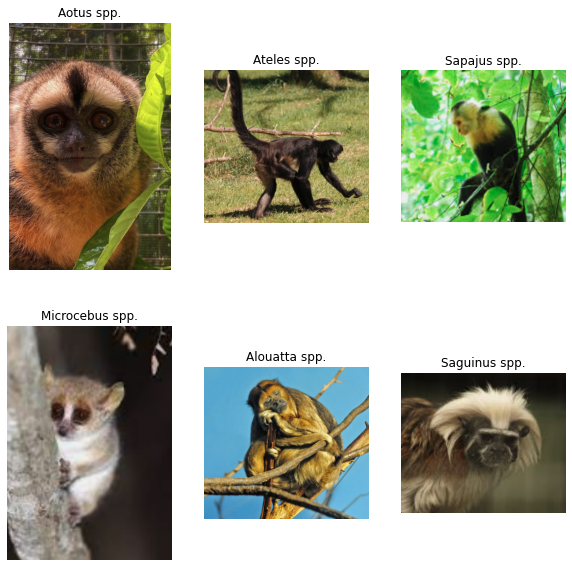

In [88]:
def show_images():   
    fig, ax = plt.subplots(2,3,figsize=(10,10))
    ax[0,0].imshow(plt.imread(aotus[random.randint(0,10)]))
    ax[0,0].set_title('Aotus spp.')
    ax[0,0].axis('off')

    ax[0,1].imshow(plt.imread(ateles[random.randint(0,10)]))
    ax[0,1].set_title('Ateles spp.')
    ax[0,1].axis('off')
 
    ax[0,2].imshow(plt.imread(sapajus[random.randint(0,10)]))
    ax[0,2].set_title('Sapajus spp.')
    ax[0,2].axis('off')
    
    ax[1,0].imshow(plt.imread(microcebus[random.randint(0,10)]))
    ax[1,0].set_title('Microcebus spp.')
    ax[1,0].axis('off')  

    ax[1,1].imshow(plt.imread(alouatta[random.randint(0,10)]))
    ax[1,1].set_title('Alouatta spp.')
    ax[1,1].axis('off')  

    ax[1,2].imshow(plt.imread(saguinus[random.randint(0,10)]))
    ax[1,2].set_title('Saguinus spp.')
    ax[1,2].axis('off') 
    
    return plt.show()
show_images()

Load with keras

In [89]:
batch_size = 32
img_height = 180
img_width = 180 

In [90]:
import pathlib
# data_dir = pathlib.Path(data_dir)

Split for training

In [91]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/Users/caremico/Documents/caremico/Primate_Recog/genus_recog/',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 157 files belonging to 6 classes.
Using 126 files for training.


Split for Validation

In [92]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  '/Users/caremico/Documents/caremico/Primate_Recog/genus_recog/',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 157 files belonging to 6 classes.
Using 31 files for validation.


In [93]:
# plt.figure(figsize=(10, 10))
# class_names = train_ds.class_names

# for images, labels in train_ds.take(1):
#     ax = plt.subplot(2, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

Configure dataset for performance

In [94]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Standardize data

In [95]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.003921569 1.0


In [96]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

Compile the model

In [97]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [98]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 45, 45, 64)       

Train model

In [99]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
4/4 [==============================] - 6s 1s/step - loss: 2.3466 - accuracy: 0.1984 - val_loss: 1.7792 - val_accuracy: 0.2581
Epoch 2/10
4/4 [==============================] - 3s 839ms/step - loss: 1.7192 - accuracy: 0.2619 - val_loss: 1.8405 - val_accuracy: 0.1290
Epoch 3/10
4/4 [==============================] - 3s 876ms/step - loss: 1.6479 - accuracy: 0.3095 - val_loss: 1.8683 - val_accuracy: 0.1290
Epoch 4/10
4/4 [==============================] - 4s 938ms/step - loss: 1.5467 - accuracy: 0.3413 - val_loss: 1.7237 - val_accuracy: 0.1613
Epoch 5/10
4/4 [==============================] - 4s 994ms/step - loss: 1.4538 - accuracy: 0.4365 - val_loss: 1.6288 - val_accuracy: 0.3226
Epoch 6/10
4/4 [==============================] - 4s 866ms/step - loss: 1.2521 - accuracy: 0.6032 - val_loss: 1.7140 - val_accuracy: 0.3226
Epoch 7/10
4/4 [==============================] - 4s 1s/step - loss: 1.0229 - accuracy: 0.6587 - val_loss: 1.3773 - val_accuracy: 0.4194
Epoch 8/10
4/4 [==========

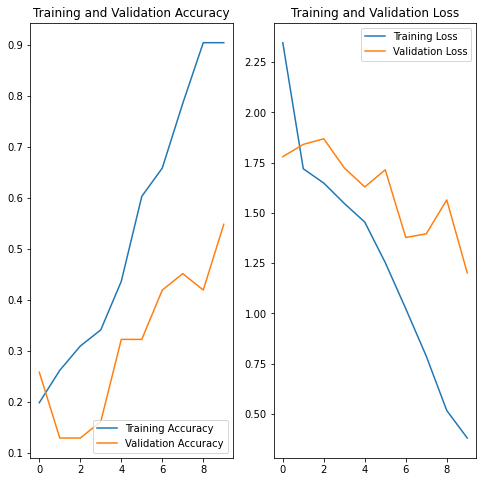

In [100]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Data Augmentation, drop out, retrain

Predict new data

Upload and Show test image

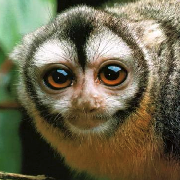

In [101]:
# test = glob('/Users/caremico/Documents/caremico/Facial_Recog/facial_recog/Aotus/Test/*.png')
test = tf.keras.utils.load_img('/Users/caremico/Documents/caremico/Primate_Recog/Test1/Aotus.png', target_size=(img_height, img_width))
test

In [102]:
img_array = tf.keras.preprocessing.image.img_to_array(test)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model.predict(img_array,3)
score = tf.nn.softmax(predictions[0])

print( "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))

1/1 [==============================] - 0s 187ms/step
This image most likely belongs to Aotus with a 97.17 percent confidence.
